In [12]:
print("This is notebook 2, and your attention is required! This is DEEP learning because the surface ain't enough!")

This is notebook 2, and your attention is required! This is DEEP learning because the surface ain't enough!


Deep learning involves using more than one hidden layer, aka the code from previous book plus some extra parametrization to get a larger number of layers in between. As opposed to hardcoding each layer, the code has been designed as scallable such that any number of layers each with any number of nodes can be used. The same data set has been used for training though it appears to show its limits. 


In [1]:
# Same data as yesterday for the moment
# import Box

# Import box
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plot
import copy 

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
# Import the data set and organise the data into training data and test data randomly

debug = True

breastCancerDataset = load_breast_cancer()

m_total = len(breastCancerDataset.target)
y = breastCancerDataset.target.reshape(m_total, 1)
x = breastCancerDataset.data[:, np.r_[0:10]]
x = preprocessing.scale(x)

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1, random_state=42)

xTrain = xTrain.T
xTest = xTest.T
yTrain = yTrain.T
yTest = yTest.T

nFeatures = xTrain.shape[0]
nNodes = nFeatures+2

if(debug):
    print("xTrain: ", xTrain.shape)
    print("nFeatures: ", nFeatures)
    print("nNodes: ", nNodes)

xTrain:  (10, 512)
nFeatures:  10
nNodes:  12


In [3]:
# the activation functions to be used

def leakyReLU(Z, slope=0.05):            # Rectified Linear Unit function
    return np.maximum(slope*Z, Z)

def deltaLeakyReLU(Z, slope=0.05):
    Z[Z>0] = 1
    Z[Z<0] = slope  
    return Z
    
def sigmoid(Z, factor=1):                # pretty much tanh(x) but not really
    return 1/(1+np.exp(-Z*factor))

def deltaSigmoid(Z, factor=1):
    return np.multiply(Z*factor, (1-Z)*factor)

def activation(Z, function):
    if(function == "leakyReLU"):
        K = leakyReLU(Z)
        return K
    else:
        return sigmoid(Z)
    
# Computing the cost after forward propagation

def costCompute(Y, A):               # cost function to be found in the coursera lectures
    sample = np.multiply(Y, np.log(A)) + np.multiply(1-Y, np.log(1.000001-A))
    sample = np.sum(sample)
    return -sample/Y.shape[1]



In [4]:
def initialiseParameters(networkParameters, X):
    Ws = []
    Bs = []
    nHiddenLayers = networkParameters[0]
    layerNodes = networkParameters[1]
    layerNodes.append(1)
    layerNodes.insert(0, X.shape[0])        #for the first hidden layer, the number of 'previous nodes' is the number of feature
    m = X.shape[1]
    
    for i in range(1, nHiddenLayers+2):
        W = np.random.rand(layerNodes[i], layerNodes[i-1])*0.01
        B = np.random.rand(layerNodes[i], 1)                         # conseil de Ambroise de ne pas mettre m (end 2eme dim)          
        previousNodes = W.shape[1]
        Ws.append(W)
        Bs.append(B)

    return (Ws, Bs)

In [5]:
def generateActivationList(nHiddenLayers):
    activationList = []
    for i in range(0, nHiddenLayers):
        activationList.append("leakyReLU")
    activationList.append(sigmoid)
    return activationList

In [6]:
def feedForwardProcess(A, W, b):   # .T --> transpose
    return np.dot(W, A)+b

In [7]:
def updateParameters(coefficientsSet, Ws, bs, learningRate=1.0):
    for i in range(nHiddenLayers, -1, -1):
        Ws[i] = Ws[i] - coefficientsSet[i]["dW"]*learningRate
        bs[i] = bs[i] - coefficientsSet[i]["db"]*learningRate
    return (Ws, bs)

def backwardPropagation(Y, Ws, bs, As, Zs, nHiddenLayers, deltaActivationList, learningRate):
    m = Y.shape[1]
   
    dZnow = As[-1] - Y                        # A[4]
    
    coefficientsSet = []
        
    # need to use delta Sigmoid    
        
    for i in range(nHiddenLayers, -1, -1):                 # counting downwards
        if(i != nHiddenLayers):
            dZnow = np.multiply(np.dot(Ws[i+1].T, dZnow), deltaLeakyReLU(Zs[i]))

        dW = 1/m*np.dot(dZnow, As[i].T)                    # not sure about the A index
        db = 1/m*np.sum(dZnow, axis=1, keepdims=True)
                                    
        coefficients = {
            "dW" : dW,
            "db" : db
        }
        coefficientsSet.append(coefficients)
    
    coefficientsSet.reverse()
    Ws, bs = updateParameters(coefficientsSet, Ws, bs, learningRate)

    return (Ws, bs)


In [8]:
def deepModel(X, Y, nLayers, networkParameters, nFeatures, nIterations=5, debug=False, 
          learningRate=0.01):
      
    Ws, bs = initialiseParameters(networkParameters, X)
    activationList = generateActivationList(networkParameters[0])
    deltaActivationList = ["deltaLeakyRelU","deltaLeakyReLU","deltaLeakyReLU","deltaSigmoid"]
    
    Cost = []
    print("Y shape: ", Y.shape)
    
    for i in range(0, nIterations):
        if(debug):
            print('\n\n\nIteration ', i)
        A = copy.deepcopy(X)
        As = []
        As.append(A)
        Zs = []
        for j in range(0, nHiddenLayers+1):
            if(debug):
                print("\n   -----------------  layer: ", j, "   ---------------------   ")
            Z = feedForwardProcess(A, Ws[j], bs[j])
            A = activation(Z, activationList[j])
            if(debug):
                print("A size: ", A.shape, " Z size: ", Z.size)
            As.append(A)
            Zs.append(Z)
        cost = costCompute(Y, A)
        Cost.append(cost)
        Ws, bs = backwardPropagation(Y, Ws, bs, As, Zs, nHiddenLayers, deltaActivationList, learningRate)
    print("Final Cost: ", cost)
    
    
    plot.figure(1)
    plot.plot(Cost)              #{-x for x in c}
    plot.ylabel('The Cost Function ($)')
    plot.xlabel('nIterations')
    plot.show()
    
    return Ws, bs
        

In [9]:
def prediction(xTest, Ws, bs, nHiddenLayers):
    activationList = generateActivationList(nHiddenLayers)
    A = copy.deepcopy(xTest)
    for j in range(0, nHiddenLayers+1):
        Z = feedForwardProcess(A, Ws[j], bs[j])
        A = activation(Z, activationList[j])
    prediction = np.round(A)
    return prediction

Y shape:  (1, 512)
Final Cost:  0.0584544961638


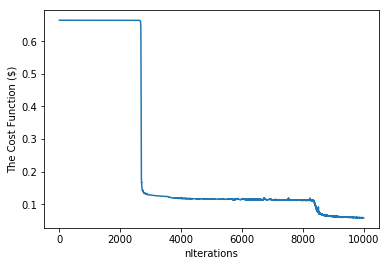

Predictions with test set: 
Accuracy: 96%
Predictions with training set: 
Accuracy: 97%
END


In [22]:
layerNodes = [10, 10, 10]
nHiddenLayers = len(layerNodes)
networkParameters = [nHiddenLayers, layerNodes]

Ws, bs = deepModel(xTrain, yTrain, 5, networkParameters, nFeatures, 10000, False, 0.5)

predictions = prediction(xTest, Ws, bs, nHiddenLayers)

print("Predictions with test set: ")
print ('Accuracy: %d' % float((np.dot(yTest, predictions.T)+ np.dot(1 - yTest, 1 - predictions.T))
                              / float(yTest.size) * 100) + '%')


predictions2 = prediction(xTrain, Ws, bs, nHiddenLayers)
print("Predictions with training set: ")
print ('Accuracy: %d' % float((np.dot(yTrain, predictions2.T)+ np.dot(1 - yTrain, 1 - predictions2.T))
                              / float(yTrain.size) * 100) + '%')


print('END')